In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
booking_data = pd.read_csv('train_data.csv', index_col='Unnamed: 0')
tripadvisor_data = pd.read_csv('test_data.csv', index_col='Unnamed: 0')

booking_data['Cleaned_Review'] = booking_data['Cleaned_Review'].fillna('')
tripadvisor_data['Cleaned_Review'] = tripadvisor_data['Cleaned_Review'].fillna('')

In [3]:
print(len(booking_data))
print(len(tripadvisor_data))

20741
1650


In [4]:
booking_data.isna().sum()

Review            0
Cleaned_Review    0
Category          0
dtype: int64

In [5]:
booking_data.head()

,Review,Cleaned_Review,Category
0,Room quality.. hotel staff.. the bar..,room quality hotel staff bar,1
1,"The bed, size of room, the bath tub feature in...",bed size room bath tub feature bathroom location,1
2,I was made very welcome at the britania Hotel ...,make welcome britania hotel exerlent reception...,1
3,Location was brilliant.,location brilliant,1
4,Syl checked me in. She was friendly and profes...,syl check friendly professional offer upgrade ...,1


In [6]:
tripadvisor_data.isna().sum()

Review            0
Category          0
Cleaned_Review    0
dtype: int64

In [21]:
tripadvisor_data.head()

,Review,Category,Cleaned_Review
0,All ok except the cost of parking We had a bud...,1,ok except cost park budget night stay well set...
1,Bad experience overall I had the worse experie...,0,bad experience overall worse experience ever f...
2,Better than expected stayed as part of a natio...,1,better expect stay part national coach trip pl...
3,Dismal I booked a double room six months in ad...,0,dismal book double room six months advance sta...
4,Good value for weekend break Service was very ...,1,good value weekend break service good room lar...


In [7]:
tripadvisor_data.head()

,Review,Category,Cleaned_Review
0,All ok except the cost of parking We had a bud...,1,ok except cost park budget night stay well set...
1,Bad experience overall I had the worse experie...,0,bad experience overall worse experience ever f...
2,Better than expected stayed as part of a natio...,1,better expect stay part national coach trip pl...
3,Dismal I booked a double room six months in ad...,0,dismal book double room six months advance sta...
4,Good value for weekend break Service was very ...,1,good value weekend break service good room lar...


In [8]:
# balanced
booking_data.Category.value_counts()

1    12104
0     8637
Name: Category, dtype: int64

# Train, Validation, Test

In [21]:
train, valid = train_test_split(booking_data, test_size=0.2, random_state=123)

In [22]:
X = booking_data.Cleaned_Review
X_train = train.Cleaned_Review
X_valid = valid.Cleaned_Review

y = booking_data.Category
y_train = train.Category
y_valid = valid.Category

y_train = y_train.astype('float64')
y_valid = y_valid.astype('float64')

In [23]:
%%time
#countvectorizer
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train)

# transform the training and validation data using count vectorizer object
X_train_count =  count_vect.transform(X_train)
X_valid_count =  count_vect.transform(X_valid)

X_train_count = X_train_count.astype('float64')
X_valid_count = X_valid_count.astype('float64')
y_train = y_train.astype('float64')
y_valid = y_valid.astype('float64')

Wall time: 294 ms


In [25]:
X_test = tripadvisor_data.Cleaned_Review
y_test = tripadvisor_data.Category

X_test = X_test.astype('str')
y_test = y_test.astype('str')

#countvectorizer
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X)

# transform the training and validation data using count vectorizer object
X_count =  count_vect.transform(X)
X_test_count =  count_vect.transform(X_test)

X_count = X_count.astype('float64')
X_test_count = X_test_count.astype('float64')

y = y.astype('float64')
y_test = y_test.astype('float64')

## Baseline - TextBlob
### Validation

In [26]:
from textblob import TextBlob

In [27]:
def tb(x):
    if TextBlob(x).sentiment[0] > 0:
        return 1
    else:
        return 0

In [28]:
df_valid = valid.copy()
df_valid['Textblob'] = df_valid.Cleaned_Review.apply(lambda x: tb(x))
df_valid.head()

,Review,Cleaned_Review,Category,Textblob
15533,Good location beautiful room,good location beautiful room,1,1
20023,No Negative,negative,0,0
18547,The room was unwelcoming very cold in look an...,room unwelcoming cold look temperature small e...,0,0
6695,Wir hatten kein Frühstück.,wir hatten kein frhstck,1,0
8488,Bed was a little uncomfortable but otherwise g...,bed little uncomfortable otherwise good stay,0,1


In [29]:
accuracy_textblob = accuracy_score(df_valid.Category, df_valid.Textblob)
print ("Accuracy: ", accuracy_textblob)

Accuracy:  0.6191853458664739


## Baseline - TextBlob
### Test

In [34]:
df_test = tripadvisor_data.copy()
df_test['Textblob'] = df_test.Cleaned_Review.apply(lambda x: tb(x))
df_test.head()

,Review,Category,Cleaned_Review,Textblob
0,All ok except the cost of parking We had a bud...,1,ok except cost park budget night stay well set...,1
1,Bad experience overall I had the worse experie...,0,bad experience overall worse experience ever f...,0
2,Better than expected stayed as part of a natio...,1,better expect stay part national coach trip pl...,1
3,Dismal I booked a double room six months in ad...,0,dismal book double room six months advance sta...,1
4,Good value for weekend break Service was very ...,1,good value weekend break service good room lar...,1


In [35]:
accuracy_textblob = accuracy_score(df_test.Category, df_test.Textblob)
print ("Accuracy: ", accuracy_textblob)

Accuracy:  0.5527272727272727


## Baseline - Vader
### Validation

In [36]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [37]:
def vd(x):
    if SentimentIntensityAnalyzer().polarity_scores(x)['compound'] > 0:
        return 1
    else:
        return 0

In [38]:
df_valid['Vader'] = df_valid.Review.apply(lambda x: vd(x))
df_valid.head()

,Review,Cleaned_Review,Category,Textblob,Vader
15533,Good location beautiful room,good location beautiful room,1,1,1
20023,No Negative,negative,0,0,0
18547,The room was unwelcoming very cold in look an...,room unwelcoming cold look temperature small e...,0,0,1
6695,Wir hatten kein Frühstück.,wir hatten kein frhstck,1,0,0
8488,Bed was a little uncomfortable but otherwise g...,bed little uncomfortable otherwise good stay,0,1,1


In [39]:
accuracy_vader = accuracy_score(df_valid.Category, df_valid.Vader)
print ("Accuracy: ", accuracy_vader)

Accuracy:  0.6372619908411665


## Baseline - Vader
### Test

In [40]:
df_test['Vader'] = df_test.Review.apply(lambda x: vd(x))
df_test.head()

,Review,Category,Cleaned_Review,Textblob,Vader
0,All ok except the cost of parking We had a bud...,1,ok except cost park budget night stay well set...,1,1
1,Bad experience overall I had the worse experie...,0,bad experience overall worse experience ever f...,0,0
2,Better than expected stayed as part of a natio...,1,better expect stay part national coach trip pl...,1,1
3,Dismal I booked a double room six months in ad...,0,dismal book double room six months advance sta...,1,0
4,Good value for weekend break Service was very ...,1,good value weekend break service good room lar...,1,1


In [41]:
accuracy_vader = accuracy_score(df_test.Category, df_test.Vader)
print ("Accuracy: ", accuracy_vader)

Accuracy:  0.6503030303030303


## RandomForest
### Validation

In [61]:
rf_tuning_params = {
    'max_depth' : np.arange(start=20, stop=70, step=10),
    'n_estimators': [i*20 for i in range(5,7)]
}

In [62]:
%%time
rf = RandomForestClassifier(max_depth=40, random_state=123)

grid = GridSearchCV(rf, rf_tuning_params, cv=5, scoring='accuracy')
grid.fit(X_count, y)

print("Best Score: ", grid.best_score_)
print("Best Params: ", grid.best_params_)

Best Score:  0.8259008862959856
Best Params:  {'max_depth': 60, 'n_estimators': 100}
Wall time: 8min 34s


### Test

In [63]:
y_pred_rf = grid.predict(X_test_count)

f1score_rf = f1_score(y_test, y_pred_rf, average='macro')
print ("RF, count Vectors: ", f1score_rf)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print ("Accuracy: ", accuracy_rf)

print(grid.best_params_)
print(classification_report(y_test, y_pred_rf))

RF, count Vectors:  0.7601669254500181
Accuracy:  0.8054545454545454
{'max_depth': 60, 'n_estimators': 100}
              precision    recall  f1-score   support

         0.0       0.89      0.84      0.86      1212
         1.0       0.62      0.70      0.66       438

    accuracy                           0.81      1650
   macro avg       0.75      0.77      0.76      1650
weighted avg       0.81      0.81      0.81      1650



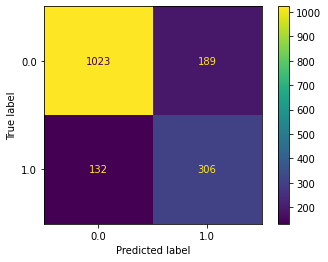

In [64]:
plot_confusion_matrix(grid, X_test_count, y_test)  
plt.show()

## XGBoost
### Validation

In [43]:
xgb_tuning_params = {
    'learning_rate': [0.01, 0.1, 0.2], 
    'max_depth' : [i for i in range(20, 30)],
    'n_estimators': [i*20 for i in range(5,10)]
}

In [65]:
%%time
xgb = XGBClassifier(n_estimators = 380, use_label_encoder=False, max_depth=20, learning_rate=0.1,
                    objective = 'binary:logistic', eval_metric = 'logloss',seed=123)

grid = GridSearchCV(xgb, xgb_tuning_params, cv=5, scoring='accuracy')
grid.fit(X_count, y)

print("Best Score: ", grid.best_score_)
print("Best Params: ", grid.best_params_)

Best Score:  0.8437883743756265
Best Params:  {'learning_rate': 0.1, 'max_depth': 26, 'n_estimators': 420}
Wall time: 2h 16min 6s


### Test

In [66]:
y_pred_xgb = grid.predict(X_test_count)

f1score_xgb = f1_score(y_test, y_pred_xgb, average='macro')
print ("xgb, count Vectors: ", f1score_xgb)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print ("Accuracy: ", accuracy_xgb)

print(grid.best_params_)
print(classification_report(y_test, y_pred_xgb))

xgb, count Vectors:  0.7370980237023852
Accuracy:  0.7715151515151515
{'learning_rate': 0.1, 'max_depth': 26, 'n_estimators': 420}
              precision    recall  f1-score   support

         0.0       0.90      0.77      0.83      1212
         1.0       0.55      0.77      0.64       438

    accuracy                           0.77      1650
   macro avg       0.73      0.77      0.74      1650
weighted avg       0.81      0.77      0.78      1650



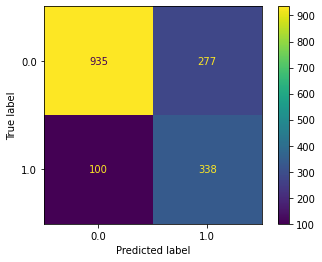

In [67]:
plot_confusion_matrix(grid, X_test_count, y_test)  
plt.show()

## LGBM
### Validation

In [54]:
lgbm_tuning_params = {
    'learning_rate': [0.01, 0.1, 0.2], #np.linspace(0.01, 0.3, 5, endpoint=True),
    'max_depth' : [i for i in range(20, 30)],
    'n_estimators': [i*20 for i in range(5,10)]
}

In [55]:
%%time
lgbm = lgb.LGBMClassifier(n_estimators = 100, max_depth=20, learning_rate=0.1,seed=123)

grid = GridSearchCV(lgbm, lgbm_tuning_params, cv=5, scoring='accuracy')
grid.fit(X_count, y)


print("Best Score: ", grid.best_score_)
print("Best Params: ", grid.best_params_)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

### Test

In [59]:
y_pred_lgbm = grid.predict(X_test_count)

f1score_lgbm = f1_score(y_test, y_pred_lgbm, average='macro')
print ("lgbm, count Vectors: ", f1score_lgbm)

accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print ("Accuracy: ", accuracy_lgbm)

print(grid.best_params_)
print(classification_report(y_test, y_pred_lgbm))

lgbm, count Vectors:  0.7374907328292855
Accuracy:  0.7612121212121212
{'learning_rate': 0.1, 'max_depth': 22, 'n_estimators': 180}
              precision    recall  f1-score   support

         0.0       0.94      0.72      0.82      1212
         1.0       0.53      0.87      0.66       438

    accuracy                           0.76      1650
   macro avg       0.73      0.80      0.74      1650
weighted avg       0.83      0.76      0.77      1650



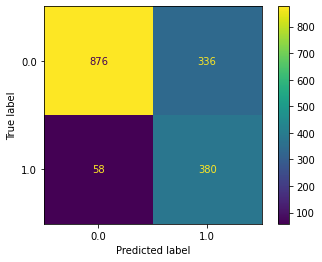

In [60]:
plot_confusion_matrix(grid, X_test_count, y_test)  
plt.show()